In [2]:
import matplotlib.pyplot as plt
import numpy as np
import progressbar

In [3]:
# honest network delay over next n blocks.
def vectorDelayHonest(ps, es, init_endorsers, delay_priority, delay_endorse):
    return (60 * len(ps)
           + delay_priority * sum(ps) 
           + sum([delay_endorse * max(init_endorsers - e, 0) for e in es]))

# attacking network delay over next n blocks.
def vectorDelayAttacker(ps, es, init_endorsers, delay_priority, delay_endorse):
    return (60 * len(ps) 
           + delay_priority * sum(ps) 
           + sum([delay_endorse * max(init_endorsers - e, 0) for e in es[1:]]))

# efficient sample generation
def getAH(alpha):
    x = np.random.geometric(1-alpha)
    if x == 1:
        h = 0
        a = np.random.geometric(alpha)
    else:
        a = 0
        h = x - 1
    return [a, h]

In [29]:
def getProbReorg(alpha, length, init_endorsers, delay_priority, delay_endorse, sample_size = int(1e5)):
    bar = progressbar.ProgressBar()
    feasible_count = 0
    for _ in range(sample_size):
        aVals = []
        hVals = []
        for i in range(length):
            a, h = getAH(alpha)
            aVals.append(a)
            hVals.append(h)
        eVals = np.random.binomial(32, alpha, size = length)
        honest_delay = vectorDelayHonest(hVals, 32 - eVals, init_endorsers, delay_priority, delay_endorse)
        selfish_delay = vectorDelayAttacker(aVals, eVals, init_endorsers, delay_priority, delay_endorse)
        if selfish_delay <= honest_delay:
            feasible_count += 1
    return feasible_count / sample_size

In [21]:
getProbReorg(alpha = 0.45, length = 20)

0.05917

In [26]:
resultsFinal2 = np.zeros((20, 4))
x = np.arange(0.3, 0.5, 0.01)
lengths = [20,35,55,80]

In [34]:
bar = progressbar.ProgressBar()
for i in bar(range(len(x))):
    for j in range(len(lengths)):
        resultsFinal2[i,j] = getProbReorg(
            x[i], 
            lengths[j], 
            init_endorsers=10, 
            delay_endorse=40,
            delay_priority=60,
            sample_size=int(1e4)
        )

100% (20 of 20) |########################| Elapsed Time: 0:02:37 Time:  0:02:37


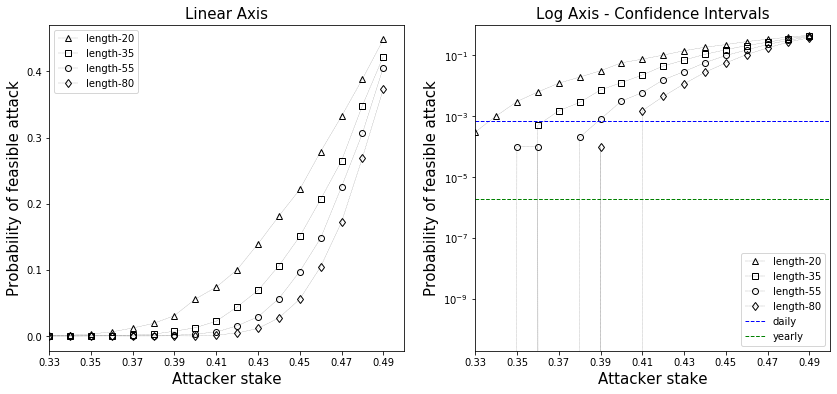

In [36]:
f, axarr = plt.subplots(ncols = 2, figsize=(14,6))
x = np.arange(0.3, 0.5, 0.01)
lengths = [20,35,55,80]
markers = ['^', 's', 'o', 'd']

for i in range(len(lengths)):
    # plotting the markers
    axarr[0].plot(x, resultsFinal2[:,i], 'k--', marker=markers[i], fillstyle='none', linewidth=0.15, 
                label=r'length-{}'.format(lengths[i]))
    axarr[1].plot(x, resultsFinal2[:,i], 'k--', marker=markers[i], fillstyle='none', linewidth=0.15, 
                label=r'length-{}'.format(lengths[i]))
    
axarr[1].axhline(1/float(24*60), color='blue', linewidth = 1, alpha=1, linestyle='--', label='daily')
axarr[1].axhline(1/float(24*60*365), color='green', linewidth = 1, alpha=1, linestyle='--', label='yearly')
for ax in axarr:
    ax.legend()
    ax.set_xlabel(r'Attacker stake', size=15)
    ax.set_ylabel(r'Probability of feasible attack', size=15)
    ax.set_xticks(np.arange(0.33, 0.5, 0.02))
    ax.set_xlim(0.33, 0.5)

axarr[1].set_yscale('log')
axarr[0].set_title('Linear Axis', size=15)
axarr[1].set_title('Log Axis - Confidence Intervals', size=15)
axarr[1].set_ylim(float(2e-11), float(1))
plt.show()